<a href="https://colab.research.google.com/github/teamgaon/lg_farm/blob/main/220121_ji_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 성능
F1-score : 0.879

여러 모델 돌려보기

옵티마이저 바꿔보기 등등

In [1]:
!nvidia-smi
# k80 -> T4 -> P100

Fri Jan 21 04:51:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 사용 패키지

In [79]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,463 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import json
import time
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip /content/drive/MyDrive/data/LG/train.zip

Archive:  /content/drive/MyDrive/data/LG/train.zip
replace train/10027/10027.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!unzip /content/drive/MyDrive/data/LG/test.zip

Archive:  /content/drive/MyDrive/data/LG/test.zip
replace test/10000/10000.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
start_time = time.time()
tr_json_list = glob('/content/train/*/*.json')
# tr_json_list = ['./data' + x[1:] for x in tr_json_list]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1287064552307129 seconds ---


In [6]:
for i, json_file in enumerate(tqdm(tr_json_list)):
    with open(json_file, 'r') as f:
        json_file = json.load(f)
    json_file_re = {
      '주목객체': json_file['annotations']['bbox'],
      '병해부위': json_file['annotations']['part'],
      '촬영부위': json_file['annotations']['area'], 
      '작물': json_file['annotations']['crop'],
      '질병명': json_file['annotations']['disease'],
      '생육단계': json_file['annotations']['grow'],
      '피해정도': json_file['annotations']['risk'],
      '이미지id': json_file['description']['image'],
      '촬영날짜': json_file['description']['date'],
      '촬영시간': json_file['description']['time'],
      'height': json_file['description']['height'],
      'width': json_file['description']['width'],
      '촬영지역': json_file['description']['region'],
      '데이터종류': json_file['description']['task']
      }
    if i == 0:
        tr_json_df = pd.json_normalize(json_file_re)
    else:
        tr_json_df = tr_json_df.append(pd.json_normalize(json_file_re))
tr_json_df = tr_json_df.reset_index(drop=True)

100%|██████████| 5767/5767 [00:30<00:00, 191.17it/s]


In [7]:
display(tr_json_df.shape, tr_json_df.head())

(5767, 14)

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류
0,"[{'x': 44.759942708333334, 'h': 500.9582083333...",[],3,1,00,11,0,29407.jpg,20210928,1034,512,682,0,0
1,"[{'x': 159.87771267361111, 'h': 340.6846168154...",[],5,3,00,11,0,21338.jpg,20210914,1000,512,384,0,0
2,"[{'x': 58.92857142857143, 'h': 203.03571428571...",[],1,3,00,13,0,53945.jpg,20210624,1332,512,384,0,0
3,"[{'x': 36.829461960565474, 'h': 478.1303323412...","[{'x': 128.99944971478175, 'h': 159.0013640873...",3,3,b3,13,1,46562.jpg,20211101,1437,512,384,0,2
4,"[{'x': 79.28571428571429, 'h': 409.28571428571...","[{'x': 86.57142857142857, 'h': 399.0, 'y': 50....",3,5,b6,13,1,29311.jpg,20211102,1202,512,384,0,2


In [8]:
tr_json_df['질병명'].unique()

array(['00', 'b3', 'b6', 'a9', 'b7', 'a5', 'b8', 'a7', 'a11', 'a12', 'b5',
       'b4'], dtype=object)

In [9]:
# crop
crop_dict = {1 : '딸기',
             2 : '토마토',
             3 : '파프리카',
             4 : '오이', 
             5 : '고추',
             6 : '시설포도'
            }    
# risk
risk_dict = {0 : '정상',
             1 : '초기',
             2 : '중기',
             3 : '말기'}

task_dict = {0 : '정상',
             1 : '병해',
             2 : '생리장해',
            }## 보호제 처리 반응 삭제 tr_json_df['데이터종류'].unique() 3없음
# disease
disease_dict = {'0' : '정상',
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

area_dict = {1 : '열매',
             2 : '꽃',
             3 : '잎',
             4 : '가지',
             5 : '줄기',
             6 : '뿌리',
             7 : '해충'}

grow_dict = {11: '유모기',
             12: '생장기',
             13: '착화/과실기',
             21: '발아기',
             22: '개화기',
             23: '신초생장기',
             24: '과실성숙기',
             25: '수확기',
             26: '휴먼기'}

In [10]:
tr_json_df['label_code'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)
print("train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}")

tr_json_df['작물'] = tr_json_df['작물'].map(crop_dict) + '(' + tr_json_df['작물'].astype(str) + ')'
tr_json_df['질병명'] = tr_json_df['질병명'].map(disease_dict) + '(' + tr_json_df['질병명'].astype(str) + ')'
tr_json_df['피해정도'] = tr_json_df['피해정도'].map(risk_dict) + '(' + tr_json_df['피해정도'].astype(str) + ')'
tr_json_df['데이터종류'] = tr_json_df['데이터종류'].map(task_dict) + '(' + tr_json_df['데이터종류'].astype(str) + ')'
tr_json_df['촬영부위'] = tr_json_df['촬영부위'].map(area_dict) + '(' + tr_json_df['촬영부위'].astype(str) + ')'
tr_json_df['생육단계'] = tr_json_df['생육단계'].map(grow_dict) + '(' + tr_json_df['생육단계'].astype(str) + ')'

tr_json_df['label_name'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)

train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}


### 일소피해 초기/말기 비교
초기랑 말기랑 다른 분포를 보임

In [11]:
tr_json_df['질병명'].unique()

array([nan, '칼슘결핍(b3)', '다량원소결핍 (N)(b6)', '파프리카흰가루병(a9)',
       '다량원소결핍 (P)(b7)', '토마토흰가루병(a5)', '다량원소결핍 (K)(b8)', '고추탄저병(a7)',
       '시설포도탄저병(a11)', '시설포도노균병(a12)', '축과병(b5)', '일소피해(b4)'],
      dtype=object)

In [12]:
tr_json_df[tr_json_df["질병명"]=="일소피해(b4)"]

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
424,"[{'x': 22.767950148809526, 'h': 362.2783668154...","[{'x': 216.6857173859127, 'h': 75.428571428571...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),12232.jpg,20210825,1309,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
486,"[{'x': 25.445831783234127, 'h': 309.3819754464...","[{'x': 52.28571041046627, 'h': 54.428555927579...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),51146.jpg,20210825,1457,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
622,"[{'x': 78.34885757688492, 'h': 302.68536086309...","[{'x': 265.7142857142857, 'h': 9.0, 'y': 342.0...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),30404.jpg,20210825,1458,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
671,"[{'x': 39.50865730406746, 'h': 349.56144593253...","[{'x': 223.66458953373015, 'h': 53.57263764880...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),19755.jpg,20210825,1309,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
959,"[{'x': 14.06253390842014, 'h': 341.51934523809...","[{'x': 129.0, 'h': 186.85712735615078, 'y': 25...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),22096.jpg,20210825,1458,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
1086,"[{'x': 143.3956221600839, 'h': 422.72037749038...","[{'x': 332.86073488290805, 'h': 166.8683808109...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),44425.jpg,20210816,0820,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
1244,"[{'x': 52.49855065724206, 'h': 339.11600942460...","[{'x': 198.2166728670635, 'h': 87.584015376984...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),67348.jpg,20210825,1305,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
1373,"[{'x': 19.419722299727184, 'h': 332.1442832341...","[{'x': 119.08571273561508, 'h': 58.97141617063...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),56710.jpg,20210825,1459,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
1986,"[{'x': 0.0, 'h': 401.7874813988095, 'y': 70.98...","[{'x': 207.85714285714286, 'h': 181.7142857142...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),51184.jpg,20210825,1308,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
2098,"[{'x': 16.604778955853174, 'h': 323.0441778273...","[{'x': 153.94286334325398, 'h': 46.97143167162...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),66030.jpg,20210825,1458,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)


In [25]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고'#, '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                #'내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'
                ]

f1 = pd.read_csv('/content/train/52342/52342.csv')[csv_features]
f2 = pd.read_csv('/content/train/51146/51146.csv')[csv_features]
f3 =  pd.read_csv('/content/train/30404/30404.csv')[csv_features]
l1 =  pd.read_csv('/content/train/59933/59933.csv')[csv_features]
l2 =  pd.read_csv('/content/train/50378/50378.csv')[csv_features]
l3 =  pd.read_csv('/content/train/57335/57335.csv')[csv_features]

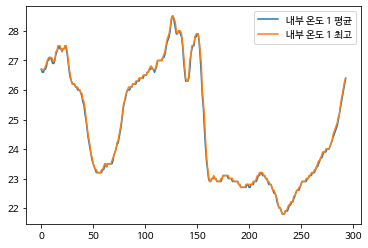

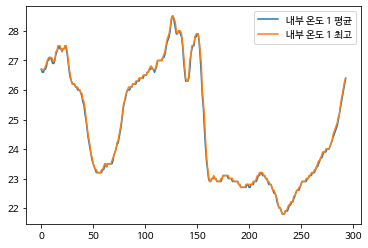

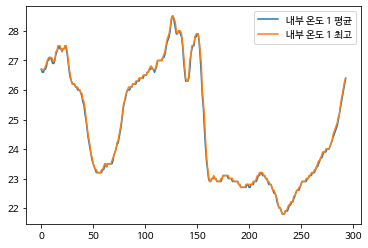

In [18]:
f1.plot()
f2.plot()
f3.plot()

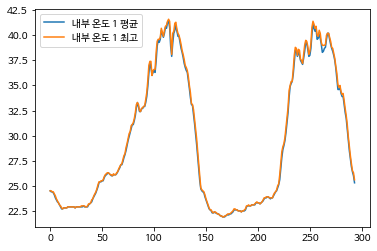

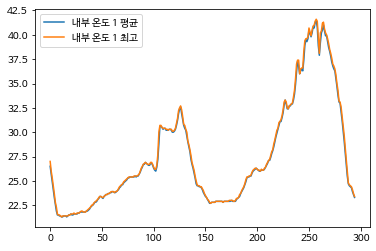

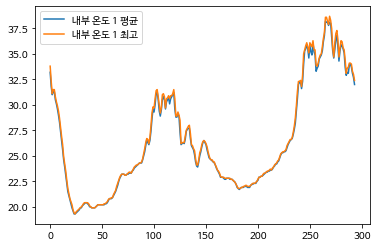

In [19]:
l1.plot()
l2.plot()
l3.plot()

### 파프리카 정상 / 칼슘결핍
분포 차이 없음 csv 불필요

In [24]:
tr_json_df[tr_json_df["질병명"]=="칼슘결핍(b3)"]


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
3,"[{'x': 36.829461960565474, 'h': 478.1303323412...","[{'x': 128.99944971478175, 'h': 159.0013640873...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),46562.jpg,20211101,1437,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
9,"[{'x': 43.784016927083336, 'h': 426.7671130952...","[{'x': 79.68784877232143, 'h': 137.94703311011...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),47731.jpg,20211101,1301,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
27,"[{'x': 46.71377418154762, 'h': 441.85869295634...","[{'x': 153.18080357142858, 'h': 61.94328962053...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),38183.jpg,20211101,1306,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
42,"[{'x': 134.59841579861111, 'h': 295.9854290674...","[{'x': 195.5365978422619, 'h': 80.358057415674...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),45719.jpg,20211103,1738,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
44,"[{'x': 93.85680183531746, 'h': 358.28698536706...","[{'x': 173.4381355406746, 'h': 86.384889632936...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),57322.jpg,20211103,1739,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,"[{'x': 26.15857902405754, 'h': 360.07682291666...","[{'x': 90.00086805555556, 'h': 100.71656436011...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),47286.jpg,20211102,1131,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
5575,"[{'x': 56.918968563988095, 'h': 445.3174913194...","[{'x': 143.9735088045635, 'h': 114.67761811755...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),44531.jpg,20211101,1438,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
5579,"[{'x': 59.48453388516865, 'h': 456.46747891865...","[{'x': 189.50975012400792, 'h': 147.3220796130...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),62587.jpg,20211101,1437,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
5725,"[{'x': 56.499918619791664, 'h': 462.4790426587...","[{'x': 163.39326016865078, 'h': 131.2519841269...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),40019.jpg,20211101,1333,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)


In [28]:
tr_json_df[tr_json_df["작물"]=="파프리카(3)"]

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
1,"[{'x': 159.87771267361111, 'h': 340.6846168154...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),21338.jpg,20210914,1000,512,384,0,정상(0),3_00_0,NaN
2,"[{'x': 58.92857142857143, 'h': 203.03571428571...",[],열매(1),파프리카(3),NaN,착화/과실기(13),정상(0),53945.jpg,20210624,1332,512,384,0,정상(0),3_00_0,NaN
3,"[{'x': 36.829461960565474, 'h': 478.1303323412...","[{'x': 128.99944971478175, 'h': 159.0013640873...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),46562.jpg,20211101,1437,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
5,"[{'x': 75.00032552083333, 'h': 287.94766865079...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),57020.jpg,20210924,1148,512,384,0,정상(0),3_00_0,NaN
9,"[{'x': 43.784016927083336, 'h': 426.7671130952...","[{'x': 79.68784877232143, 'h': 137.94703311011...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),47731.jpg,20211101,1301,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5757,"[{'x': 161.78571428571428, 'h': 205.1785714285...",[],열매(1),파프리카(3),NaN,착화/과실기(13),정상(0),41237.jpg,20210624,1429,512,384,0,정상(0),3_00_0,NaN
5760,"[{'x': 84.5024646577381, 'h': 146.297510540674...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),64346.jpg,20210928,1236,512,242,0,정상(0),3_00_0,NaN
5763,"[{'x': 76.51248604910714, 'h': 187.41888330853...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),25506.jpg,20210914,1633,512,242,0,정상(0),3_00_0,NaN
5764,"[{'x': 75.85713510664682, 'h': 284.44577752976...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),27774.jpg,20210927,1154,512,384,0,정상(0),3_00_0,NaN


In [33]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']
f_b3_1 = pd.read_csv('/content/train/58687/58687.csv')[csv_features]
f_b3_2 = pd.read_csv('/content/train/40019/40019.csv')[csv_features]
f_b3_3 =  pd.read_csv('/content/train/62587/62587.csv')[csv_features]

n_b3_1 = pd.read_csv('/content/train/21338/21338.csv')[csv_features]
n_b3_2 = pd.read_csv('/content/train/27774/27774.csv')[csv_features]
n_b3_3 =  pd.read_csv('/content/train/25506/25506.csv')[csv_features]

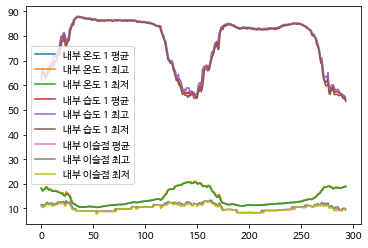

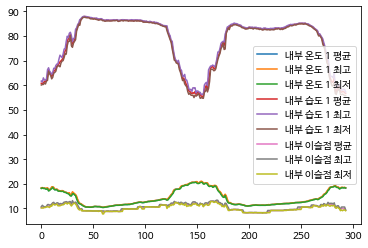

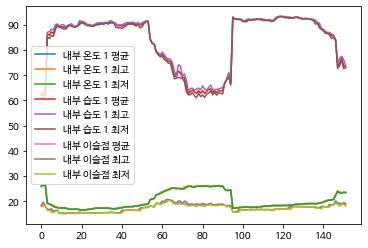

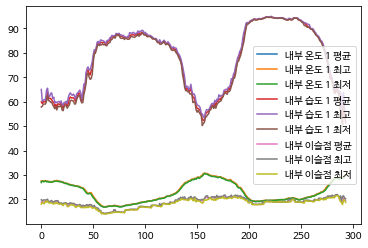

In [35]:
f_b3_2.plot()
f_b3_3.plot()

n_b3_2.plot()
n_b3_3.plot()

### 질병별로 csv가 다른 분포를 보이는가
파프리카의 질병별 분포 확인  
다른 분포를 보임

In [40]:

# nan, '칼슘결핍(b3)', '다량원소결핍 (N)(b6)', '파프리카흰가루병(a9)',
#       '다량원소결핍 (P)(b7)', '토마토흰가루병(a5)', '다량원소결핍 (K)(b8)', '고추탄저병(a7)',
#       '시설포도탄저병(a11)', '시설포도노균병(a12)', '축과병(b5)', '일소피해(b4)'

tr_json_df[tr_json_df["작물"]=="파프리카(3)"]["질병명"].unique()

array([nan, '칼슘결핍(b3)', '파프리카흰가루병(a9)', '다량원소결핍 (P)(b7)',
       '다량원소결핍 (K)(b8)', '다량원소결핍 (N)(b6)'], dtype=object)

In [52]:
tr_json_df[(tr_json_df["작물"]=="파프리카(3)") & (tr_json_df["질병명"]=='다량원소결핍 (N)(b6)')]

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
78,"[{'x': 74.83462766617063, 'h': 449.77926587301...","[{'x': 102.60830543154762, 'h': 283.1371837797...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),18321.jpg,20211103,1541,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
88,"[{'x': 83.11614118303571, 'h': 392.12081473214...","[{'x': 84.09399801587301, 'h': 287.97898065476...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),12841.jpg,20211102,1628,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
101,"[{'x': 122.5142841641865, 'h': 276.57142857142...","[{'x': 123.88571118551587, 'h': 274.0571676587...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),29886.jpg,20211103,1745,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
153,"[{'x': 88.47117590525794, 'h': 337.88318452380...","[{'x': 90.69408792162699, 'h': 333.43737599206...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),61838.jpg,20211103,1004,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
185,"[{'x': 62.04032583085318, 'h': 448.30704365079...","[{'x': 123.08212425595238, 'h': 179.623046875,...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),21262.jpg,20211103,1534,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,"[{'x': 84.499431630291, 'h': 354.0189318783069...","[{'x': 85.61638661541005, 'h': 213.13671875, '...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),49448.jpg,20211103,1535,512,682,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
5448,"[{'x': 27.002185546875, 'h': 388.06, 'y': 61.7...","[{'x': 28.54516796875, 'h': 382.6595625, 'y': ...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),30464.jpg,20211029,1308,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
5504,"[{'x': 109.82135106646825, 'h': 338.8430679563...","[{'x': 111.83029513888889, 'h': 334.1555059523...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),44221.jpg,20211103,1750,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
5576,"[{'x': 23.017291356646826, 'h': 454.1083519345...","[{'x': 27.202605716765873, 'h': 237.5175161210...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),35019.jpg,20211103,1542,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)


In [53]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']
# 정상 착화/과실기
n3 = pd.read_csv('/content/train/41237/41237.csv')[csv_features]
# 다량원소결핍 (N)(b6) 
b6 = pd.read_csv('/content/train/66064/66064.csv')[csv_features]
# 파프리카흰가루병(a9)
a9 =  pd.read_csv('/content/train/57327/57327.csv')[csv_features]
# 다량원소결핍 (K)(b8)
b8 = pd.read_csv('/content/train/60523/60523.csv')[csv_features]
# 다량원소결핍 (P)(b7)
b7 = pd.read_csv('/content/train/49667/49667.csv')[csv_features]


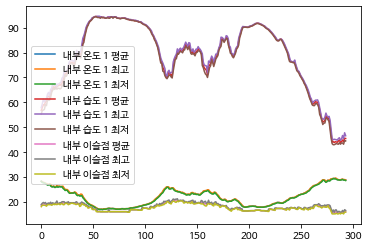

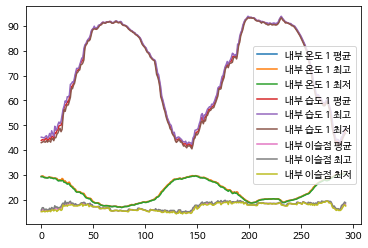

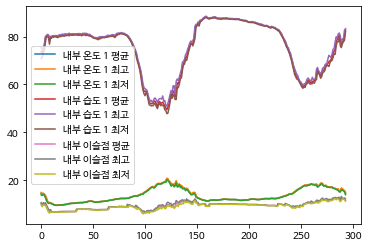

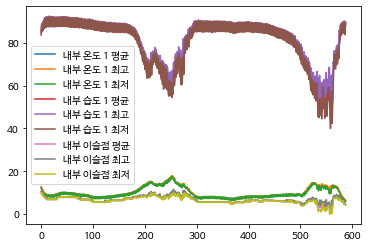

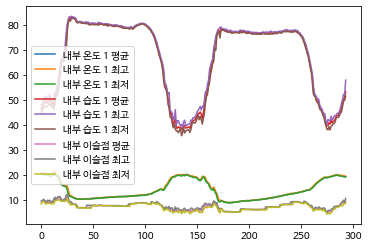

In [54]:
n3.plot()
a9.plot()
b8.plot()
b7.plot()
b6.plot()

### 같은 질병인 애들이 어떤 분포를 보이는가
흰가루병  
식물이 달라도 같은 질병이면 같은 분포를 보인다 

In [55]:
tr_json_df[tr_json_df["데이터종류"]=="병해(1)"]["질병명"].unique()

array(['파프리카흰가루병(a9)', '토마토흰가루병(a5)', '고추탄저병(a7)', '시설포도탄저병(a11)',
       '시설포도노균병(a12)'], dtype=object)

In [60]:
tr_json_df[tr_json_df["질병명"]=="토마토흰가루병(a5)"]

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
25,"[{'x': 120.0, 'h': 251.57142857142858, 'y': 12...","[{'x': 125.57142857142857, 'h': 85.71428571428...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),13240.jpg,20211017,1247,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
137,"[{'x': 96.26092819940476, 'h': 356.58882068452...","[{'x': 205.0791015625, 'h': 57.757347470238095...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),15468.jpg,20211019,1645,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
260,"[{'x': 82.86866784474206, 'h': 189.17492869543...","[{'x': 238.3938957093254, 'h': 47.544844370039...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),47221.jpg,20211019,1645,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
361,"[{'x': 164.57142857142858, 'h': 201.7671440972...","[{'x': 165.71428571428572, 'h': 63.42857142857...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),50572.jpg,20211013,0926,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
430,"[{'x': 160.00115740740742, 'h': 379.0569196428...","[{'x': 432.15426587301585, 'h': 53.63921957671...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),45163.jpg,20211017,1252,512,682,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,"[{'x': 79.68708147321429, 'h': 373.23533606150...","[{'x': 91.74078466021825, 'h': 61.607824900793...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),32280.jpg,20211013,1725,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
5639,"[{'x': 138.42857142857142, 'h': 202.2857142857...","[{'x': 143.7257099454365, 'h': 71.314267113095...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),31261.jpg,20211017,1243,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
5649,"[{'x': 66.42856367807539, 'h': 179.57142857142...","[{'x': 104.57142857142857, 'h': 35.57142857142...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),13761.jpg,20211017,1248,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
5670,"[{'x': 249.1439525462963, 'h': 131.81359540343...","[{'x': 423.5159970238095, 'h': 21.869543650793...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),55002.jpg,20211017,1318,512,682,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)


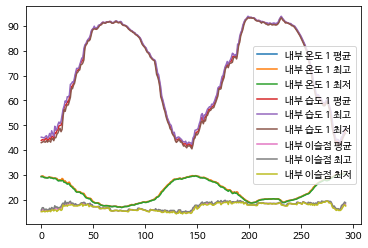

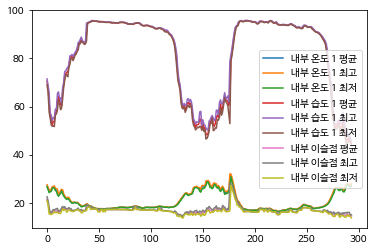

In [61]:

csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

# 파프리카흰가루병(a9)
a9 =  pd.read_csv('/content/train/57327/57327.csv')[csv_features]
# 토마토흰가루병(a5)
a5 = pd.read_csv('/content/train/36341/36341.csv')[csv_features]

a9.plot()
a5.plot()

#### 탄저병
식물이 다르고 같은 질병이면 다른 분포를 보인다

In [65]:
tr_json_df[tr_json_df["질병명"]=='시설포도탄저병(a11)']

#'시설포도탄저병(a11)',

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
140,"[{'x': 0.0, 'h': 354.1682083333333, 'y': 156.2...","[{'x': 321.42997916666667, 'h': 151.786375, 'y...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),중기(2),59957.jpg,20210830,1519,512,682,0,병해(1),6_a11_2,시설포도(6)_시설포도탄저병(a11)_중기(2)
264,"[{'x': 80.3574921875, 'h': 258.48328125, 'y': ...","[{'x': 229.207921875, 'h': 29.5240625, 'y': 25...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),25846.jpg,20210818,1240,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
360,"[{'x': 47.57197808159722, 'h': 502.56241319444...","[{'x': 265.28878038194443, 'h': 68.57222222222...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),21571.jpg,20210827,1643,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
396,"[{'x': 14.730277894035218, 'h': 326.1210317460...","[{'x': 196.71431671626985, 'h': 76.28597780257...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),64576.jpg,20210902,1444,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
429,"[{'x': 64.285125, 'h': 275.8959375, 'y': 141.2...","[{'x': 138.057140625, 'h': 19.657140625, 'y': ...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),19697.jpg,20210818,1241,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
441,"[{'x': 0.0, 'h': 384.08599950396825, 'y': 78.3...","[{'x': 205.028568328373, 'h': 60.5714285714285...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),46873.jpg,20210902,1455,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
468,"[{'x': 132.00153125, 'h': 254.241984375, 'y': ...","[{'x': 239.418203125, 'h': 36.033359375, 'y': ...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),55505.jpg,20210818,1241,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
931,"[{'x': 0.8357473706442212, 'h': 445.9500248015...","[{'x': 213.44996279761904, 'h': 77.42910621279...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),18154.jpg,20210902,1455,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
1074,"[{'x': 77.00847904265873, 'h': 325.45005580357...","[{'x': 148.3883308531746, 'h': 31.817305307539...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),42989.jpg,20210902,1456,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
1353,"[{'x': 44.19561476934524, 'h': 403.12949528769...","[{'x': 197.14287264384922, 'h': 64.45737227182...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),53736.jpg,20210902,1742,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)


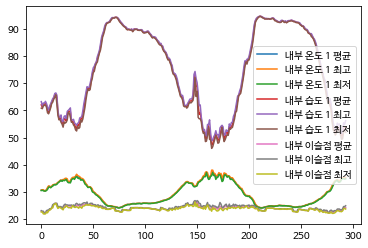

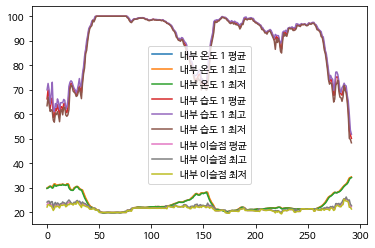

In [66]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']
# 중기로 비교
# 고추탄저병(a7)
a7 =  pd.read_csv('/content/train/12793/12793.csv')[csv_features]
# 시설포도탄저병(a11)
a11 = pd.read_csv('/content/train/19548/19548.csv')[csv_features]

a7.plot()
a11.plot()